<a href="https://colab.research.google.com/github/vinayprabhu/Crimes_of_Vison_Datasets/blob/master/Notebooks/CelebA_HQ_glow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the drive and chdir into your project directory:

In [1]:
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/gdrive')
import os
os.chdir('/gdrive/My Drive/Colab Notebooks/Glow/glow/demo')
# !ls

TensorFlow 1.x selected.
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Download the assets:
```
! git clone https://github.com/openai/glow.git
!pip install -r requirements.txt
!curl https://storage.googleapis.com/glow-demo/celeba-hq/x.npy > x.npy
!curl https://storage.googleapis.com/glow-demo/celeba-hq/attr.npy > attr.npy
!curl https://storage.googleapis.com/glow-demo/celeba-hq/z.npy > z.npy

#   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
#                                  Dload  Upload   Total   Spent    Left  Speed
# 100 5625M  100 5625M    0     0  31.6M      0  0:02:57  0:02:57 --:--:-- 36.4M
#   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
#                                  Dload  Upload   Total   Spent    Left  Speed
# 100 9375k  100 9375k    0     0  17.2M      0 --:--:-- --:--:-- --:--:-- 17.2M
#   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
#                                  Dload  Upload   Total   Spent    Left  Speed
# 100 21.9G  100 21.9G    0     0  33.6M      0  0:11:09  0:11:09 --:--:-- 34.7M
```

# The basic imports and attribute vec declaration:

In [2]:
_TAGS = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
_TAGS = _TAGS.split()
##################################
import pickle
import numpy as np
# import model
from align_face import align_face
from PIL import Image
from tqdm import tqdm

print('Loading z..')
z = np.load('z.npy',mmap_mode='r')
print('Loading x..')
x = np.load('x.npy',mmap_mode='r')
z_manipulate = np.load('z_manipulate.npy')
attr = np.load('attr.npy')

print(attr.shape,x.shape,z.shape,z_manipulate.shape)

Loading z..
Loading x..
(30000, 40) (30000, 256, 256, 3) (30000, 196608) (40, 196608)


In [3]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
from PIL import Image
from threading import Lock

lock = Lock()


def get(name):
    return tf.get_default_graph().get_tensor_by_name('import/' + name + ':0')


def tensorflow_session():
    # Init session and params
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # Pin GPU to local rank (one GPU per process)
    config.gpu_options.visible_device_list = str(0)
    sess = tf.Session(config=config)
    return sess


optimized = False
if optimized:
    # Optimized model. Twice as fast as
    # 1. we freeze conditional network (label is always 0)
    # 2. we use fused kernels
    import blocksparse
    graph_path = 'graph_optimized.pb'
    inputs = {
        'dec_eps_0': 'dec_eps_0',
        'dec_eps_1': 'dec_eps_1',
        'dec_eps_2': 'dec_eps_2',
        'dec_eps_3': 'dec_eps_3',
        'dec_eps_4': 'dec_eps_4',
        'dec_eps_5': 'dec_eps_5',
        'enc_x': 'input/enc_x',
    }
    outputs = {
        'dec_x': 'model_3/Cast_1',
        'enc_eps_0': 'model_2/pool0/truediv_1',
        'enc_eps_1': 'model_2/pool1/truediv_1',
        'enc_eps_2': 'model_2/pool2/truediv_1',
        'enc_eps_3': 'model_2/pool3/truediv_1',
        'enc_eps_4': 'model_2/pool4/truediv_1',
        'enc_eps_5': 'model_2/truediv_4'
    }

    def update_feed(feed_dict, bs):
        return feed_dict
else:
    graph_path = 'graph_unoptimized.pb'
    inputs = {
        'dec_eps_0': 'Placeholder',
        'dec_eps_1': 'Placeholder_1',
        'dec_eps_2': 'Placeholder_2',
        'dec_eps_3': 'Placeholder_3',
        'dec_eps_4': 'Placeholder_4',
        'dec_eps_5': 'Placeholder_5',
        'enc_x': 'input/image',
        'enc_x_d': 'input/downsampled_image',
        'enc_y': 'input/label'
    }
    outputs = {
        'dec_x': 'model_1/Cast_1',
        'enc_eps_0': 'model/pool0/truediv_1',
        'enc_eps_1': 'model/pool1/truediv_1',
        'enc_eps_2': 'model/pool2/truediv_1',
        'enc_eps_3': 'model/pool3/truediv_1',
        'enc_eps_4': 'model/pool4/truediv_1',
        'enc_eps_5': 'model/truediv_4'
    }

    def update_feed(feed_dict, bs):
        x_d = 128 * np.ones([bs, 128, 128, 3], dtype=np.uint8)
        y = np.zeros([bs], dtype=np.int32)
        feed_dict[enc_x_d] = x_d
        feed_dict[enc_y] = y
        return feed_dict

with tf.gfile.GFile(graph_path, 'rb') as f:
    graph_def_optimized = tf.GraphDef()
    graph_def_optimized.ParseFromString(f.read())


def run(sess, fetches, feed_dict):
    with lock:
        # Locked tensorflow so average server response time to user is lower
        result = sess.run(fetches, feed_dict)
    return result


def flatten_eps(eps):
    # [BS, eps_size]
    return np.concatenate([np.reshape(e, (e.shape[0], -1)) for e in eps], axis=-1)


def unflatten_eps(feps):
    index = 0
    eps = []
    bs = feps.shape[0]  # feps.size // eps_size
    for shape in eps_shapes:
        eps.append(np.reshape(
            feps[:, index: index+np.prod(shape)], (bs, *shape)))
        index += np.prod(shape)
    return eps


def encode(img):
    if len(img.shape) == 3:
        img = np.expand_dims(img, 0)
    bs = img.shape[0]
    assert img.shape[1:] == (256, 256, 3)
    feed_dict = {enc_x: img}

    update_feed(feed_dict, bs)  # For unoptimized model
    return flatten_eps(run(sess, enc_eps, feed_dict))


def decode(feps):
    if len(feps.shape) == 1:
        feps = np.expand_dims(feps, 0)
    bs = feps.shape[0]
    # assert len(eps) == n_eps
    # for i in range(n_eps):
    #     shape = (BATCH_SIZE, 128 // (2 ** i), 128 // (2 ** i), 6 * (2 ** i) * (2 ** (i == (n_eps - 1))))
    #     assert eps[i].shape == shape
    eps = unflatten_eps(feps)

    feed_dict = {}
    for i in range(n_eps):
        feed_dict[dec_eps[i]] = eps[i]

    update_feed(feed_dict, bs)  # For unoptimized model
    return run(sess, dec_x, feed_dict)


def project(z):
    return np.dot(z, z_proj)


def _manipulate(z, dz, alpha):
    z = z + alpha * dz
    return decode(z), z


def _manipulate_range(z, dz, points, scale):
    z_range = np.concatenate(
        [z + scale*(pt/(points - 1)) * dz for pt in range(0, points)], axis=0)
    return decode(z_range), z_range


# alpha from [0,1]
def mix(z1, z2, alpha):
    dz = (z2 - z1)
    return _manipulate(z1, dz, alpha)


def mix_range(z1, z2, points=5):
    dz = (z2 - z1)
    return _manipulate_range(z1, dz, points, 1.)


# alpha goes from [-1,1]
def manipulate(z, typ, alpha):
    dz = z_manipulate[typ]
    return _manipulate(z, dz, alpha)


def manipulate_all(z, typs, alphas):
    dz = 0.0
    for i in range(len(typs)):
        dz += alphas[i] * z_manipulate[typs[i]]
    return _manipulate(z, dz, 1.0)


def manipulate_range(z, typ, points=5, scale=1):
    dz = z_manipulate[typ]
    return _manipulate_range(z - dz, 2*dz, points, scale)


def random(bs=1, eps_std=0.7):
    feps = np.random.normal(scale=eps_std, size=[bs, eps_size])
    return decode(feps), feps
def get_aligned(img_paths):
    xs = []
    for img_path in img_paths:
        img = Image.open(img_path)
        img = np.reshape(np.array(img), [1, 256, 256, 3])
#         img = img.convert('RGB')  # if image is RGBA or Grayscale etc
        
#         img = np.array(img)
        x, face_found = align_face(img)
        print(face_found)
#         if face_found:
        xs.append(x)
    x = np.concatenate(xs, axis=0)
    return x

In [4]:
sess = tensorflow_session()
tf.import_graph_def(graph_def_optimized)

print("Loaded model")

n_eps = 6

# Encoder
enc_x = get(inputs['enc_x'])
enc_eps = [get(outputs['enc_eps_' + str(i)]) for i in range(n_eps)]
if not optimized:
    enc_x_d = get(inputs['enc_x_d'])
    enc_y = get(inputs['enc_y'])

# Decoder
dec_x = get(outputs['dec_x'])
dec_eps = [get(inputs['dec_eps_' + str(i)]) for i in range(n_eps)]

eps_shapes = [(128, 128, 6), (64, 64, 12), (32, 32, 24),
              (16, 16, 48), (8, 8, 96), (4, 4, 384)]
eps_sizes = [np.prod(e) for e in eps_shapes]
eps_size = 256 * 256 * 3

Loaded model


In [5]:
_img, _z = random(1)
_z = encode(_img)
print("Warm started tf model")

Warm started tf model


# Let us now visualize the attribute-wise prototypical images that are decoded from the 40 attribute-wise _manipulation codes_

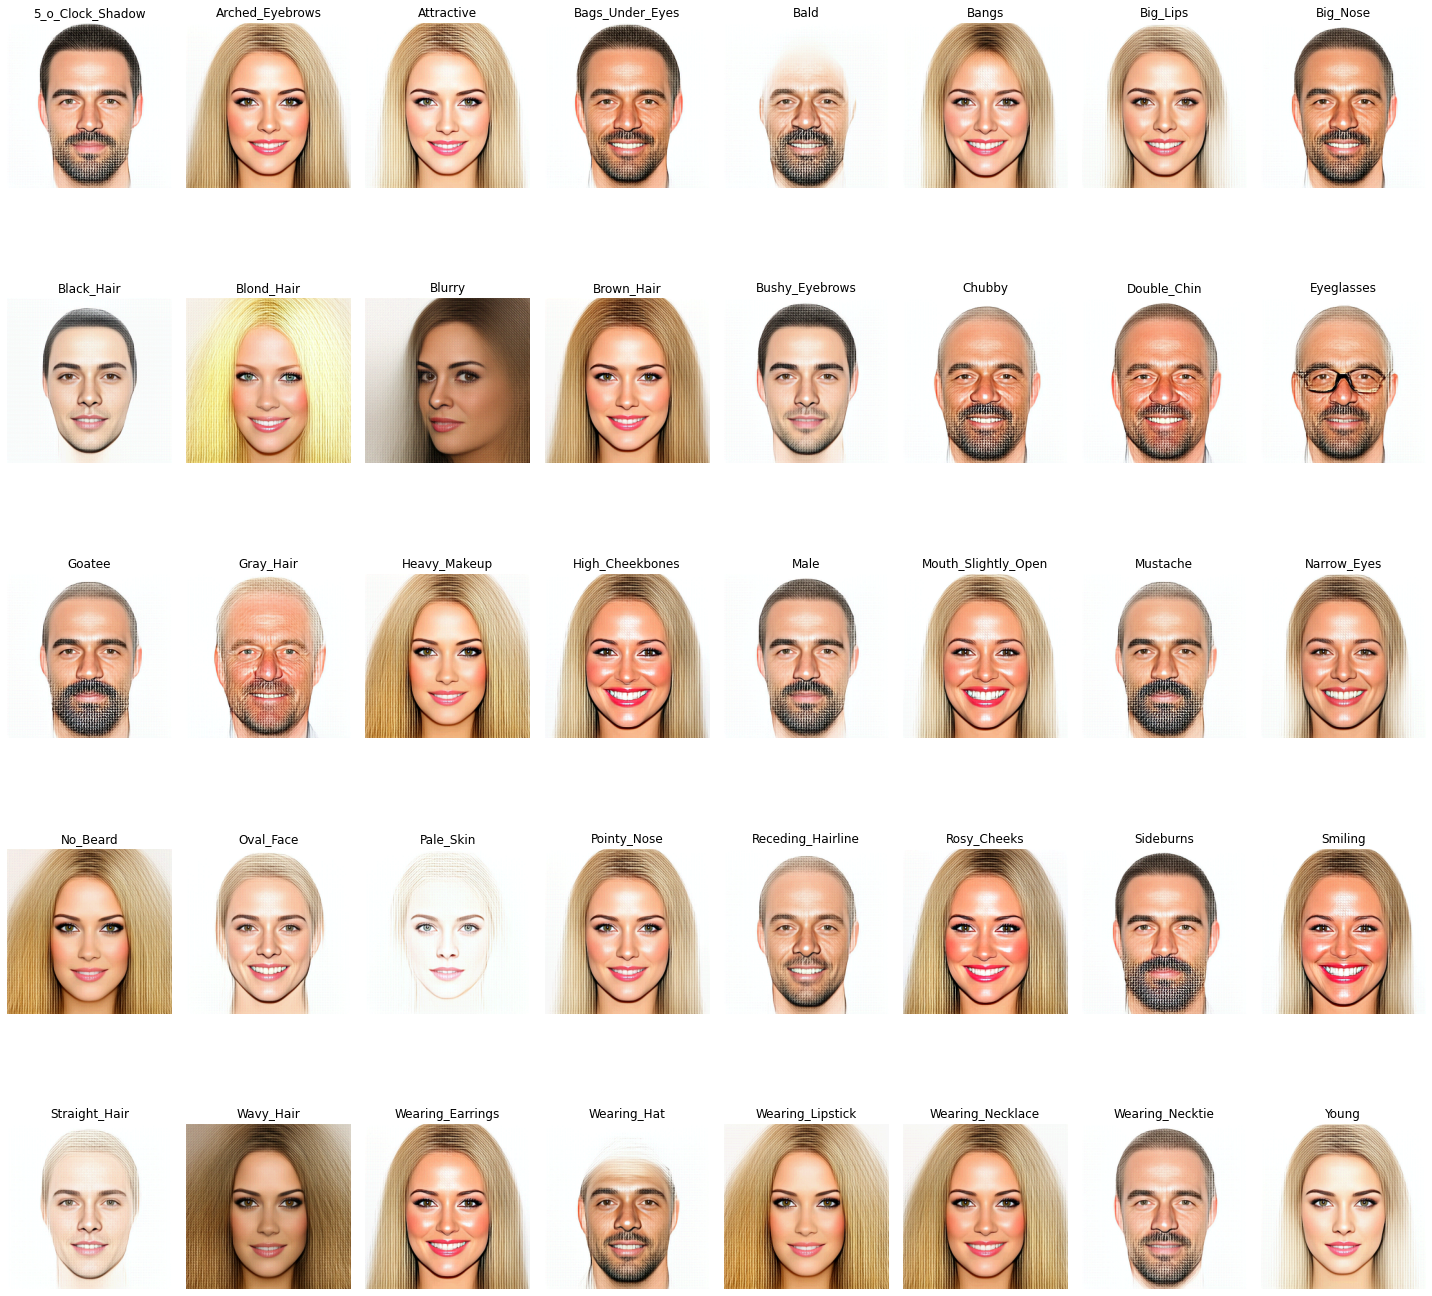

In [7]:
import matplotlib.pyplot as plt

x_attrib_40=np.zeros((40,256,256,3))

plt.figure(figsize=(20,20))
for i in range(40):
  dec_i = decode(z_manipulate[i])
  plt.subplot(5,8,i+1)
  plt.imshow(dec_i[0]);
  plt.axis('Off')
  plt.title(_TAGS[i])
  x_attrib_40[i]=dec_i
plt.tight_layout()

np.save('x_attrib_40.npy',x_attrib_40)


# 1: Exploring attractiveness and paleness:

In [8]:
print(_TAGS.index('Attractive'),_TAGS.index('Male'),_TAGS.index('Pale_Skin'))
# What percentage of the dataset is :
# FEMALE, ATTRACTIVE and PALE-SKINNED ?
perc_3=((attr[:,20]==-1)&(attr[:,2]==+1)&(attr[:,26]==+1)).mean()
perc_3


2 20 26


0.0339

In [9]:
# Of the images that are 'attractive', how many are female and pale-skinned?
ind_attractive=np.where(attr[:,2]==+1)[0]
attractive_mat=attr[ind_attractive]
import pandas as pd
df_attractive=pd.DataFrame(data=attractive_mat[:,[20,26]],columns=['Male','Pale_Skin'])
df_attractive.head()


Male  Pale_Skin
0    -1         -1
1    -1         -1
2    -1          1
3    -1         -1
4    -1         -1

In [10]:
df_attractive['male_pale_skin']=list(zip(df_attractive.Male,df_attractive.Pale_Skin))
df_attractive.male_pale_skin.value_counts()/df_attractive.shape[0]

(-1, -1)    0.741317
(1, -1)     0.189685
(-1, 1)     0.059066
(1, 1)      0.009931
Name: male_pale_skin, dtype: float64

In [11]:
df_attractive.male_pale_skin.value_counts()

(-1, -1)    12764
(1, -1)      3266
(-1, 1)      1017
(1, 1)        171
Name: male_pale_skin, dtype: int64

So, 5.9% of all 'attractive' images are female and 'pale_skinned'.
 Now, let us see, in the overall dataset, what percentage of images are 'Attractive', 'female' and 'Pale-skinned'

In [12]:
((attr[:,2]==+1) & (attr[:,20]==-1) & (attr[:,26]==+1)).mean()

0.0339

In [13]:
print(_TAGS.index('Attractive'),_TAGS.index('Male'),_TAGS.index('Pale_Skin'))

2 20 26


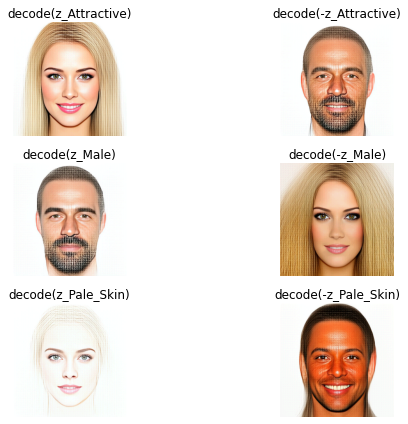

In [14]:
attrib_vec=[_TAGS.index('Attractive'),_TAGS.index('Male'),_TAGS.index('Pale_Skin')]
attr_vec_str=['Attractive','Male','Pale_Skin']

plt.figure(figsize=(9,6))
i=0
j=1
for i in range(3):
  plt.subplot(3,2,j)
  plt.imshow(decode(z_manipulate[attrib_vec[i]])[0]);
  plt.axis('Off')
  plt.title(f'decode(z_{attr_vec_str[i]})')
  plt.subplot(3,2,j+1)
  plt.imshow(decode(-z_manipulate[attrib_vec[i]])[0]);
  plt.axis('Off')
  plt.title(f'decode(-z_{attr_vec_str[i]})');
  j+=2
plt.tight_layout()


In [15]:
ind_amp=np.where((attr[:,2]==+1) & (attr[:,20]==-1) & (attr[:,26]==+1))[0]
N_grid=int(np.ceil(np.sqrt(len(ind_amp))))
N_grid

32

In [18]:
len(ind_amp)

1017

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


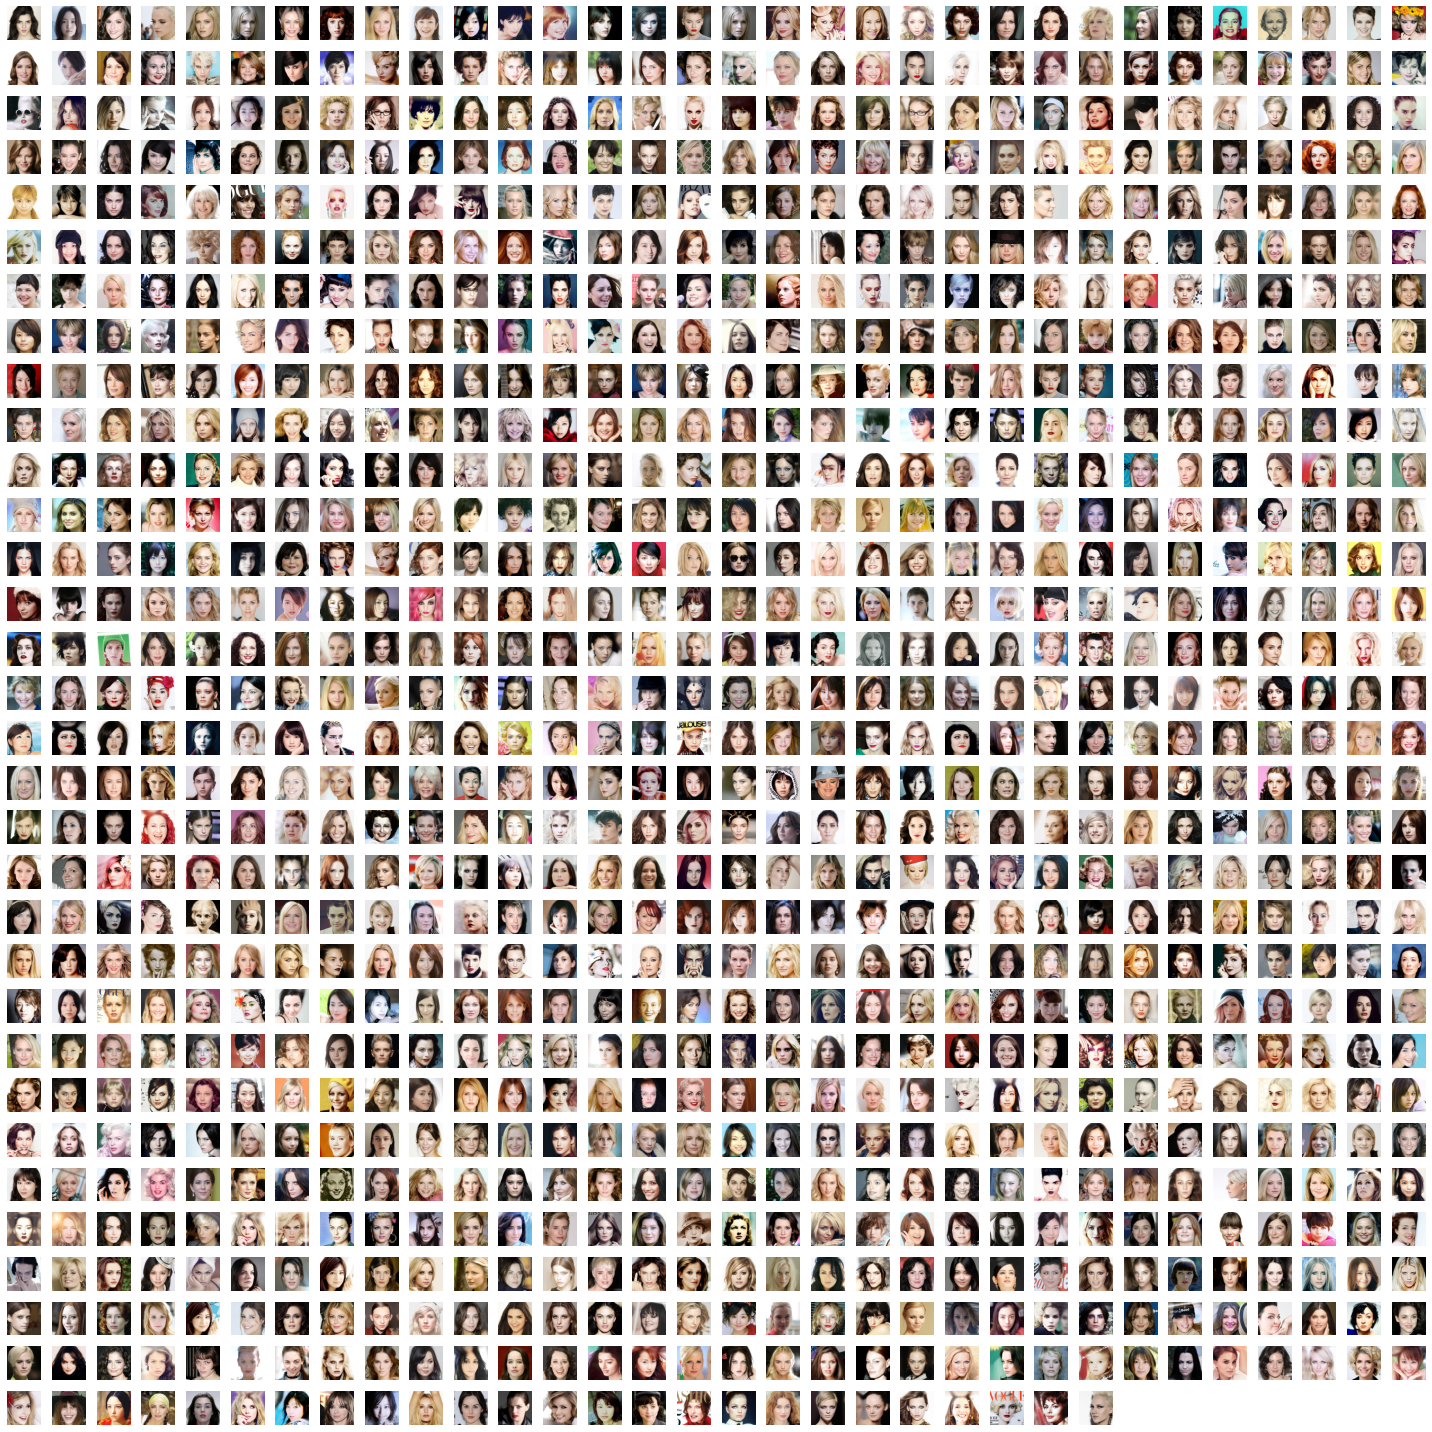

In [16]:
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in tqdm_notebook(range(len(ind_amp))):
  plt.subplot(N_grid,N_grid,i+1)
  plt.imshow(x[ind_amp[i]]);
  plt.axis('Off')
plt.tight_layout()